In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time

warnings.filterwarnings(action='ignore')

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [3]:
type(mnist)

sklearn.utils._bunch.Bunch

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [6]:
X = mnist.data
y = mnist.target

In [7]:
X.shape, y.shape

((70000, 784), (70000,))

In [8]:
format(X.shape)

'(70000, 784)'

In [9]:
# img = X[0].reshape((28,28))
# plt.imshow(img, cmap = plt.cm.binary)
# plt.show()

In [10]:
some_digit = X[1]
some_digit_img = some_digit.reshape(28, 28)
some_digit_img.shape

(28, 28)

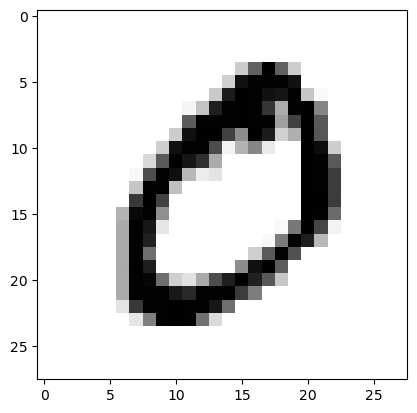

In [11]:
plt.imshow(some_digit_img, cmap='binary')

In [12]:
y = y.astype(np.uint8)
for i in X:
    i = i.reshape(28,28)
X_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
(y_train == 0).sum() # 60000개의 훈련 데이터 중 0의 개수는 5923개(대략 10%)

5923

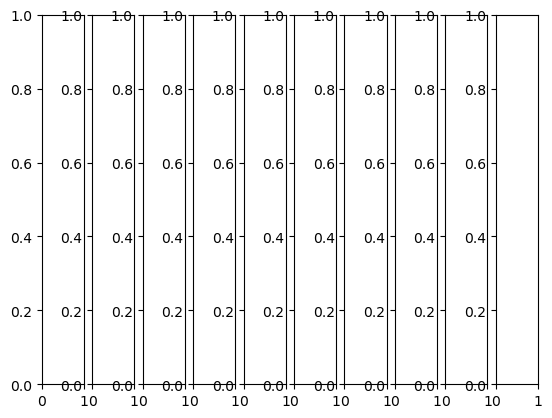

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=10)

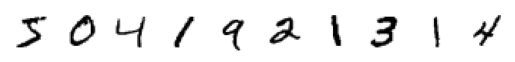

In [14]:
# 데이터 셋 X의 첫 10개 이미지 출력
fig, ax = plt.subplots(nrows=1, ncols=10)
for i in range(10):
  img = X[i].reshape((28, 28))     # 784 -> 28 * 28 변환
  ax[i].imshow(img, cmap=plt.cm.binary)     # i번째 subplot에 이미지를 그림
  ax[i].axis('off')     # 좌표축 (레이블)을 제거

plt.show()

In [15]:
# 레이블(타겟) y의 첫 10개 값을 출력
y[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [16]:
# 레이블(타겟) y는 문자열 타입 -> 숫자로 변환 
y = y.astype(np.int16)     # 16bit(=2byte) 정수
y[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int16)

In [17]:
# train / test 셋 분리
n = 60_000     # 훈련 셋의 데이터 개수
X_train, y_train = X[:n], y[:n]     # 0 <= i < 60_000
x_test, y_test = X[n:], y[n:]     # 60_000 <= i < 70_000
X_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [18]:
# 5와 5가 아닌 숫자를 분류하는 문제
y_train_5 = (y_train == 5)     # 5는 True, 다른 숫자는 False
y_test_5 = (y_test ==5)  

In [19]:
y_train_5[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

In [20]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

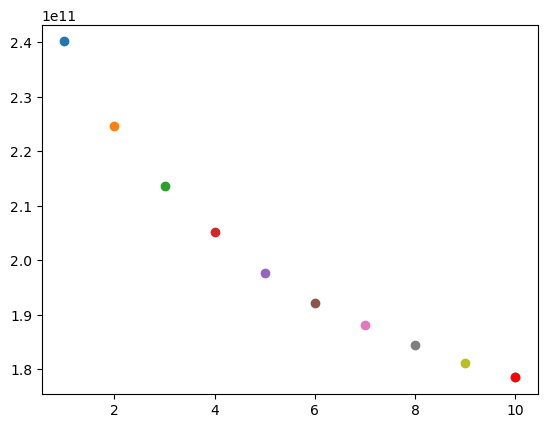

In [21]:
for k in range(1, 11):

  # K-means 알고리즘을 실행
  model = KMeans(n_clusters=k)
  model.fit(X)

  # 클러스터 내 제곱 합(WCSS) 계산
  wcss = model.inertia_

  # WCSS를 플로팅
  plt.plot(k, wcss, "o")

# 팔꿈치 지점 플로팅
plt.plot(k, wcss, "ro")
plt.show()

In [22]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [23]:
clusters = [1,2,3,4,5,6,7,8,9,10,20,256]

# test different numbers of clusters
for n_clusters in clusters:
    start = time.time()
    estimator = KMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    end = time.time()
    print(f"{end - start:.5f} sec")
    print('Accuracy: {}\n'.format(metrics.accuracy_score(y, predicted_Y)))


Number of Clusters: 1
Inertia: 240098211342.11554
Homogeneity: 0.0
1.17832 sec
Accuracy: 0.11252857142857142

Number of Clusters: 2
Inertia: 224609793062.49063
Homogeneity: 0.10601718183457046
5.24718 sec
Accuracy: 0.20732857142857142

Number of Clusters: 3
Inertia: 213604856340.25372
Homogeneity: 0.2114829455246103
7.08845 sec
Accuracy: 0.29754285714285716

Number of Clusters: 4
Inertia: 205222220730.71304
Homogeneity: 0.3025095589028088
10.41062 sec
Accuracy: 0.37615714285714286

Number of Clusters: 5
Inertia: 197606836983.4116
Homogeneity: 0.3896712109858499
7.80090 sec
Accuracy: 0.4525142857142857

Number of Clusters: 6
Inertia: 192102850256.57455
Homogeneity: 0.39911266249428334
10.49616 sec
Accuracy: 0.4737142857142857

Number of Clusters: 7
Inertia: 188104385961.46625
Homogeneity: 0.43205552366635586
15.15455 sec
Accuracy: 0.5091571428571429

Number of Clusters: 8
Inertia: 184475642826.56534
Homogeneity: 0.4779920094197049
12.57217 sec
Accuracy: 0.5787571428571429

Number of Clu

(10, 784)


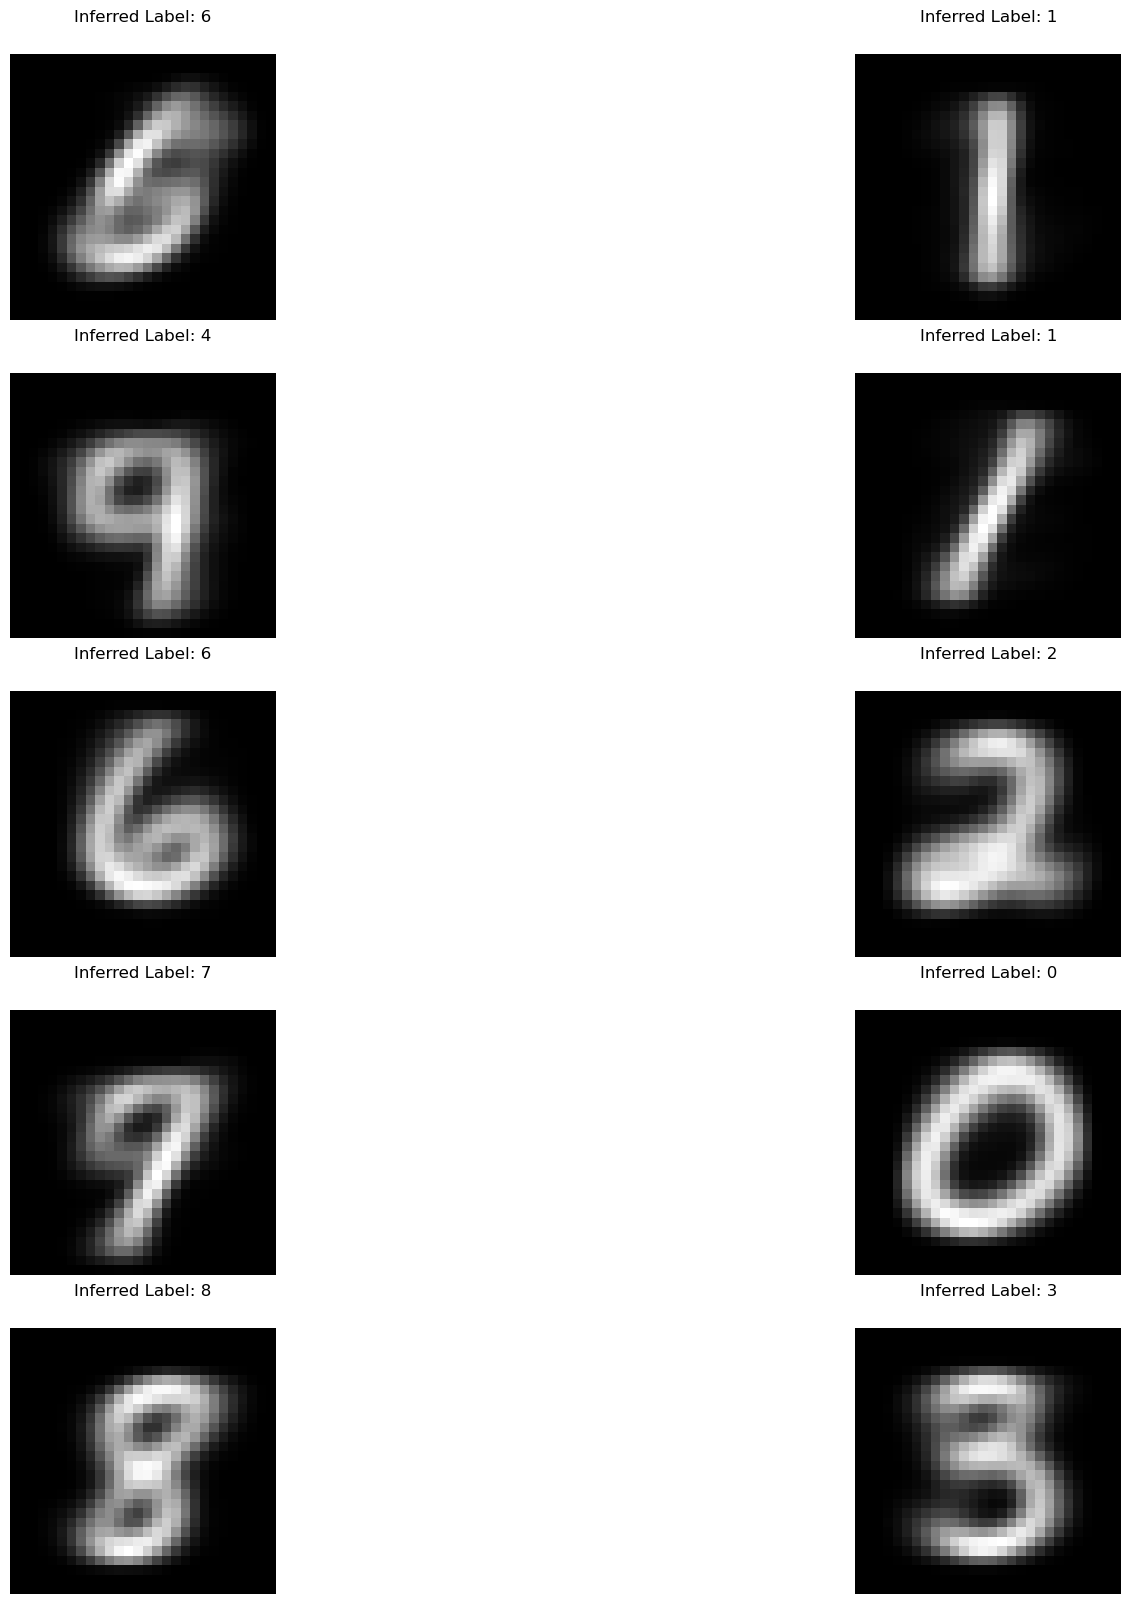

In [24]:
# Initialize and fit KMeans algorithm
kmeans = KMeans(n_clusters = 10)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

print(centroids.shape)

# reshape centroids into images
images = centroids.reshape(10, 28, 28)
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(5, 2, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

In [25]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(n_clusters=10)

In [26]:
kmeans.labels_
mnist['cluster'] = kmeans.fit_predict(X)

In [27]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    start = time.time()
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    end = time.time()
    print(f"{end - start:.5f} sec")
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(y, predicted_Y)))

Number of Clusters: 10
Inertia: 179385794514.18457
Homogeneity: 0.48225224238282677
0.91418 sec
Accuracy: 0.5999142857142857

Number of Clusters: 16
Inertia: 167563569419.5093
Homogeneity: 0.5567804795592324
0.89412 sec
Accuracy: 0.6513285714285715

Number of Clusters: 36
Inertia: 148349114850.80786
Homogeneity: 0.6778970720197921
0.96019 sec
Accuracy: 0.7600428571428571

Number of Clusters: 64
Inertia: 136528316608.57117
Homogeneity: 0.7501636186908971
1.31386 sec
Accuracy: 0.8092571428571429

Number of Clusters: 144
Inertia: 122985929562.22806
Homogeneity: 0.8067692689221442
1.78488 sec
Accuracy: 0.8659285714285714

Number of Clusters: 256
Inertia: 114204782479.12328
Homogeneity: 0.8442361593414418
2.75435 sec
Accuracy: 0.8992142857142857



In [28]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)

predicted_Y = infer_data_labels(kmeans.labels_, cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y, predicted_Y)))

Accuracy: 0.8978857142857143



(256, 784)


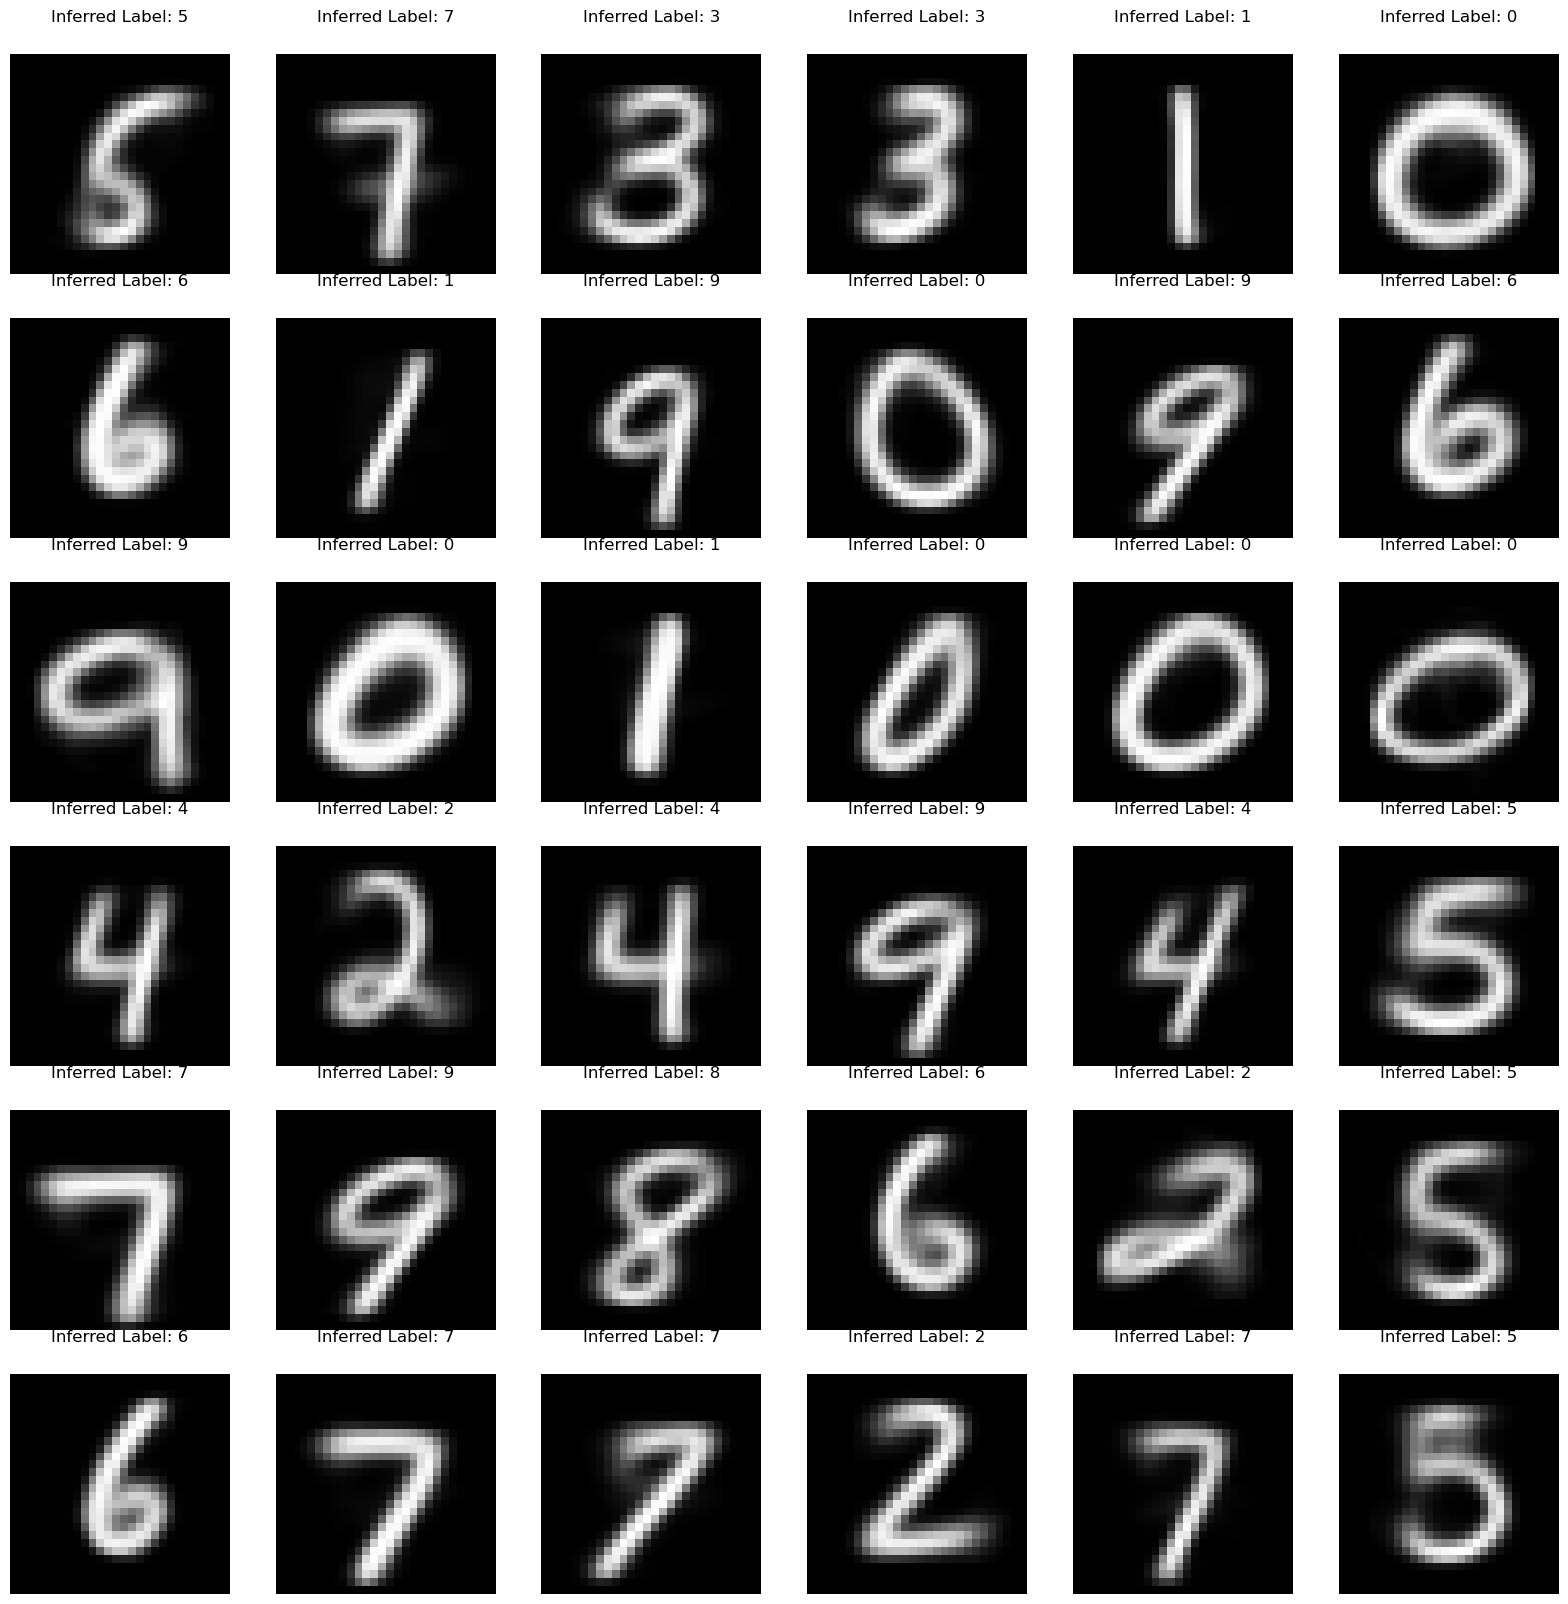

In [29]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

print(centroids.shape)

# reshape centroids into images
images = centroids.reshape(256, 28, 28)
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()